### Impoting Libraries

In [8]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report, accuracy_score, roc_auc_score
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
import pandas as pd
from sklearn.feature_selection import RFE

### Loading Dataset 

In [10]:
# Step 1: Load the dataset
file_path = 'diabetes_binary_health_indicators_BRFSS2015.csv'  # Replace with your file path
df = pd.read_csv(file_path)

In [12]:
df.head()

Diabetes_binary  HighBP  HighChol  CholCheck   BMI  Smoker  Stroke  \
0              0.0     1.0       1.0        1.0  40.0     1.0     0.0   
1              0.0     0.0       0.0        0.0  25.0     1.0     0.0   
2              0.0     1.0       1.0        1.0  28.0     0.0     0.0   
3              0.0     1.0       0.0        1.0  27.0     0.0     0.0   
4              0.0     1.0       1.0        1.0  24.0     0.0     0.0   

   HeartDiseaseorAttack  PhysActivity  Fruits  ...  AnyHealthcare  \
0                   0.0           0.0     0.0  ...            1.0   
1                   0.0           1.0     0.0  ...            0.0   
2                   0.0           0.0     1.0  ...            1.0   
3                   0.0           1.0     1.0  ...            1.0   
4                   0.0           1.0     1.0  ...            1.0   

   NoDocbcCost  GenHlth  MentHlth  PhysHlth  DiffWalk  Sex   Age  Education  \
0          0.0      5.0      18.0      15.0       1.0  0.0   9.0        4.0   
1          1.0      3.0       0.0       0.0       0.0  0.0   7.0        6.0   
2          1.0      5.0      30.0      30.0       1.0  0.0   9.0        4.0   
3          0.0      2.0       0.0       0.0       0.0  0.0  11.0        3.0   
4          0.0      2.0       3.0       0.0       0.0  0.0  11.0        5.0   

   Income  
0     3.0  
1     1.0  
2     8.0  
3     6.0  
4     4.0  

[5 rows x 22 columns]

### Data Preprocessing & Balancing

In [14]:
# Step 2: Handle missing values (imputation)
imputer = SimpleImputer(strategy='median')
df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

# Step 3: Separate features and target variable
X = df_imputed.drop('Diabetes_binary', axis=1)
y = df_imputed['Diabetes_binary']

# Step 4: Normalize or scale the data
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Step 5: Apply SMOTE for balancing the dataset
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_scaled, y)

### Spliting data into train, test and validation 

In [16]:
# Step 6: Split the dataset into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X_smote, y_smote, test_size=0.3, random_state=42, stratify=y_smote)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Check the balanced class distribution in the resampled dataset
print("Balanced class distribution in training set:")
print(y_train.value_counts())

Balanced class distribution in training set:
Diabetes_binary
1.0    152834
0.0    152833
Name: count, dtype: int64


In [18]:
# Display the shape of training, validation, and testing sets
print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Testing set shape:", X_test.shape)

Training set shape: (305667, 21)
Validation set shape: (65500, 21)
Testing set shape: (65501, 21)


In [22]:
pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 10.4 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


## XGBoost for Diabetes Prediction

In [24]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Initialize the XGBoost model
xgb_model = XGBClassifier(random_state=42)

# Step 2: Set up Hyperparameter Tuning for XGBoost
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': [0, 0.01, 0.1],
    'reg_lambda': [1, 1.5, 2],
}

# Step 3: Randomized Search for XGBoost Hyperparameters
random_search_xgb = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_grid, 
                                       n_iter=10, cv=3, verbose=2, random_state=42, n_jobs=-1)

# Step 4: Fit the model to training data
random_search_xgb.fit(X_train, y_train)

# Step 5: Best parameters after search
best_params_xgb = random_search_xgb.best_params_
print(f"Best hyperparameters for XGBoost: {best_params_xgb}")

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best hyperparameters for XGBoost: {'subsample': 0.8, 'reg_lambda': 2, 'reg_alpha': 0.1, 'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 0.2, 'colsample_bytree': 0.8}


### Evaluating XGBoost 

In [25]:
# Step 6: Evaluate the XGBoost model on validation set
y_val_pred_xgb = random_search_xgb.predict(X_val)
y_val_prob_xgb = random_search_xgb.predict_proba(X_val)[:, 1]  # For ROC-AUC calculation

# Step 7: Evaluate metrics
accuracy_xgb = accuracy_score(y_val, y_val_pred_xgb)
roc_auc_xgb = roc_auc_score(y_val, y_val_prob_xgb)
classification_rep_xgb = classification_report(y_val, y_val_pred_xgb)

print(f"XGBoost Validation Accuracy: {accuracy_xgb}")
print(f"XGBoost Validation ROC-AUC: {roc_auc_xgb}")
print("Classification Report for XGBoost:\n", classification_rep_xgb)

XGBoost Validation Accuracy: 0.9161221374045802
XGBoost Validation ROC-AUC: 0.9690643748033332
Classification Report for XGBoost:
               precision    recall  f1-score   support

         0.0       0.87      0.97      0.92     32750
         1.0       0.97      0.86      0.91     32750

    accuracy                           0.92     65500
   macro avg       0.92      0.92      0.92     65500
weighted avg       0.92      0.92      0.92     65500



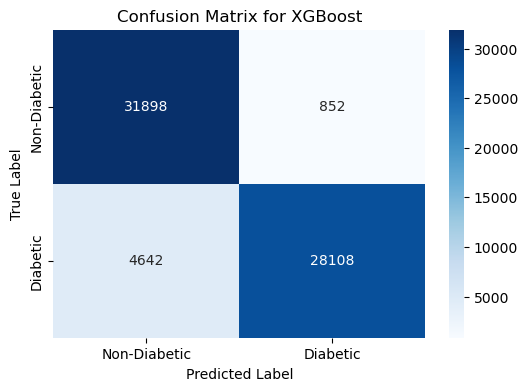

In [26]:
# Step 8: Confusion Matrix for XGBoost
cm_xgb = confusion_matrix(y_val, y_val_pred_xgb)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_xgb, annot=True, fmt="d", cmap="Blues", xticklabels=['Non-Diabetic', 'Diabetic'], yticklabels=['Non-Diabetic', 'Diabetic'])
plt.title('Confusion Matrix for XGBoost')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

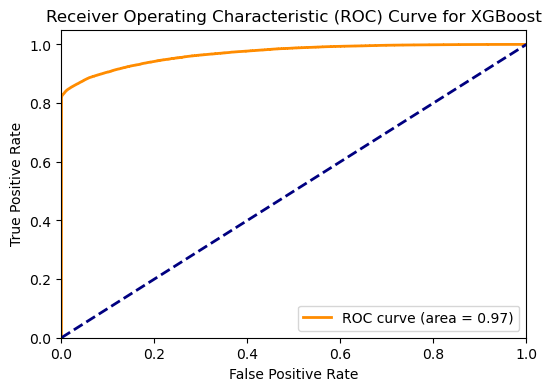

In [27]:
# Step 9: ROC Curve for XGBoost
fpr_xgb, tpr_xgb, _ = roc_curve(y_val, y_val_prob_xgb)
roc_auc = auc(fpr_xgb, tpr_xgb)

plt.figure(figsize=(6, 4))
plt.plot(fpr_xgb, tpr_xgb, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for XGBoost')
plt.legend(loc="lower right")
plt.show()

### Testing XGBoost 

In [28]:
# Step 10: Run the best XGBoost model on test data
y_test_pred_xgb = random_search_xgb.best_estimator_.predict(X_test)
y_test_prob_xgb = random_search_xgb.best_estimator_.predict_proba(X_test)[:, 1]  # For ROC-AUC calculation on test data

# Step 11: Evaluate metrics on the test set
test_accuracy_xgb = accuracy_score(y_test, y_test_pred_xgb)
test_roc_auc_xgb = roc_auc_score(y_test, y_test_prob_xgb)
test_classification_rep_xgb = classification_report(y_test, y_test_pred_xgb)

print(f"XGBoost Test Accuracy: {test_accuracy_xgb}")
print(f"XGBoost Test ROC-AUC: {test_roc_auc_xgb}")
print("Classification Report for XGBoost on Test Set:\n", test_classification_rep_xgb)

XGBoost Test Accuracy: 0.9175585105570907
XGBoost Test ROC-AUC: 0.970868454340069
Classification Report for XGBoost on Test Set:
               precision    recall  f1-score   support

         0.0       0.88      0.97      0.92     32751
         1.0       0.97      0.86      0.91     32750

    accuracy                           0.92     65501
   macro avg       0.92      0.92      0.92     65501
weighted avg       0.92      0.92      0.92     65501



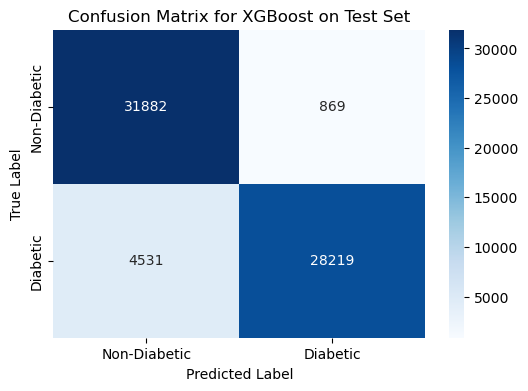

In [29]:
# Step 12: Confusion Matrix for XGBoost on the test set
cm_test_xgb = confusion_matrix(y_test, y_test_pred_xgb)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_test_xgb, annot=True, fmt="d", cmap="Blues", xticklabels=['Non-Diabetic', 'Diabetic'], yticklabels=['Non-Diabetic', 'Diabetic'])
plt.title('Confusion Matrix for XGBoost on Test Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

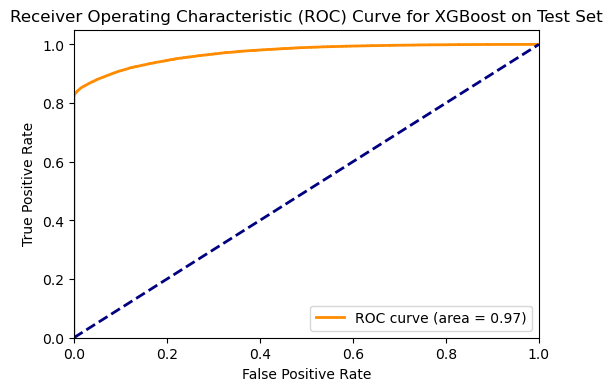

In [30]:
# Step 13: ROC Curve for XGBoost on the test set
fpr_test_xgb, tpr_test_xgb, _ = roc_curve(y_test, y_test_prob_xgb)
roc_auc_test_xgb = auc(fpr_test_xgb, tpr_test_xgb)

plt.figure(figsize=(6, 4))
plt.plot(fpr_test_xgb, tpr_test_xgb, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_test_xgb:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for XGBoost on Test Set')
plt.legend(loc="lower right")
plt.show()

### Random Forest for Diabetes Prediction

In [38]:
# Perform Feature Selection using Recursive Feature Elimination (RFE)
selector = RFE(RandomForestClassifier(random_state=42), n_features_to_select=10)
selector = selector.fit(X_train, y_train)
X_train_reduced = selector.transform(X_train)
X_val_reduced = selector.transform(X_val)

# Set up Hyperparameter Tuning using RandomizedSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Randomized search over parameters
random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_grid, 
                                   n_iter=10, cv=3, verbose=2, random_state=42, n_jobs=-1)

# Perform cross-validation during hyperparameter tuning
random_search.fit(X_train_reduced, y_train)

# Best hyperparameters after search
best_params = random_search.best_params_
print(f"Best hyperparameters: {best_params}")

[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=7, n_estimators=300, reg_alpha=0.1, reg_lambda=1.5, subsample=0.8; total time=  24.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=5, n_estimators=100, reg_alpha=0.01, reg_lambda=1.5, subsample=1.0; total time=   8.5s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=7, n_estimators=200, reg_alpha=0.1, reg_lambda=2, subsample=0.8; total time=  30.8s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=7, n_estimators=300, reg_alpha=0.1, reg_lambda=1.5, subsample=0.8; total time=  24.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=5, n_estimators=100, reg_alpha=0.01, reg_lambda=1.5, subsample=1.0; total time=   8.6s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=7, n_estimators=200, reg_alpha=0.1, reg_lambda=2, subsample=0.8; total time=  30.6s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, m

### Evaluating Random Forest 

In [46]:
# Step 1: Train the model using the best hyperparameters
rf_best_model = random_search.best_estimator_

# Step 2: Make predictions on the validation set
y_val_pred = rf_best_model.predict(X_val_reduced)
y_val_prob_rf = rf_best_model.predict_proba(X_val_reduced)[:, 1]  # For ROC-AUC calculation

# Step 3: Evaluate the model on the validation set
accuracy = accuracy_score(y_val, y_val_pred)
roc_auc = roc_auc_score(y_val, y_val_prob)
classification_rep = classification_report(y_val, y_val_pred)

print(f"Validation Accuracy: {accuracy}")
print(f"Validation ROC-AUC: {roc_auc}")
print("Classification Report:")
print(classification_rep)

NameError: name 'y_val_prob' is not defined

In [ ]:
# Step 4: Confusion Matrix for validation set
cm = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Non-Diabetic', 'Diabetic'], yticklabels=['Non-Diabetic', 'Diabetic'])
plt.title('Confusion Matrix - Validation Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
# Step 5: ROC Curve for validation set
fpr, tpr, _ = roc_curve(y_val, y_val_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Validation Set')
plt.legend(loc="lower right")
plt.show()

### Testing Random Forest

In [ ]:
# Step 7: Testing the model on the test set
# Assuming you used RFE for feature selection, apply the same transformation to X_test
X_test_reduced = selector.transform(X_test)
y_test_pred = rf_best_model.predict(X_test_reduced)
y_test_prob = rf_best_model.predict_proba(X_test_reduced)[:, 1]  # For ROC-AUC calculation

# Step 8: Evaluate the model on the test set
test_accuracy = accuracy_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, y_test_prob)
test_classification_rep = classification_report(y_test, y_test_pred)

print(f"Test Accuracy: {test_accuracy}")
print(f"Test ROC-AUC: {test_roc_auc}")
print("Test Classification Report:")
print(test_classification_rep)

In [ ]:
# Step 9: Confusion Matrix for test set
test_cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(test_cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Non-Diabetic', 'Diabetic'], yticklabels=['Non-Diabetic', 'Diabetic'])
plt.title('Confusion Matrix - Test Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
# Step 10: ROC Curve for test set
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_prob)
test_roc_auc = auc(fpr_test, tpr_test)

plt.figure(figsize=(6, 4))
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label=f'ROC curve (area = {test_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Set')
plt.legend(loc="lower right")
plt.show()

### Support Vector Machine (SVM) for Diabetes Prediction

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Initialize the SVM model (with probability=True for ROC-AUC)
svm_model = SVC(probability=True, random_state=42)

# Step 2: Set up hyperparameter grid for tuning
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

# Step 3: Perform Grid Search with cross-validation (GridSearchCV)
grid_search_svm = GridSearchCV(estimator=svm_model, param_grid=param_grid, 
                               cv=3, verbose=2, n_jobs=-1)

# Step 4: Fit the model to the training data
grid_search_svm.fit(X_train, y_train)

# Step 5: Evaluate the model
y_val_pred_svm = grid_search_svm.predict(X_val)
y_val_prob_svm = grid_search_svm.predict_proba(X_val)[:, 1]  # For ROC-AUC calculation
svm_accuracy = accuracy_score(y_val, y_val_pred_svm)

print(f"Best parameters for SVM: {grid_search_svm.best_params_}")
print(f"SVM Accuracy: {svm_accuracy:.4f}")
print("Classification Report for SVM:\n", classification_report(y_val, y_val_pred_svm))

# Confusion matrix
cm_svm = confusion_matrix(y_val, y_val_pred_svm)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_svm, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix for SVM')
plt.show()

# ROC Curve
fpr_svm, tpr_svm, _ = roc_curve(y_val, y_val_prob_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)
plt.figure(figsize=(6, 4))
plt.plot(fpr_svm, tpr_svm, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_svm:.2f})')
plt.title('ROC Curve for SVM')
plt.legend(loc="lower right")
plt.show()

In [22]:
pip install lightgbm

Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for lightgbm from https://files.pythonhosted.org/packages/d9/28/3be76b591a2e14a031b681b8283acf1dec2ad521f6f1701b7957df68c466/lightgbm-4.5.0-py3-none-win_amd64.whl.metadata
   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   - -------------------------------------- 0.0/1.4 MB 653.6 kB/s eta 0:00:03
   --------- ------------------------------ 0.3/1.4 MB 3.0 MB/s eta 0:00:01
   ------------------------------ --------- 1.1/1.4 MB 6.9 MB/s eta 0:00:01
   ---------------------------------------- 1.4/1.4 MB 7.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


### LightGBM for Diabetes Prediction

Fitting 3 folds for each of 54 candidates, totalling 162 fits
[LightGBM] [Info] Number of positive: 152834, number of negative: 152833
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017869 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3960
[LightGBM] [Info] Number of data points in the train set: 305667, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500002 -> initscore=0.000007
[LightGBM] [Info] Start training from score 0.000007
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

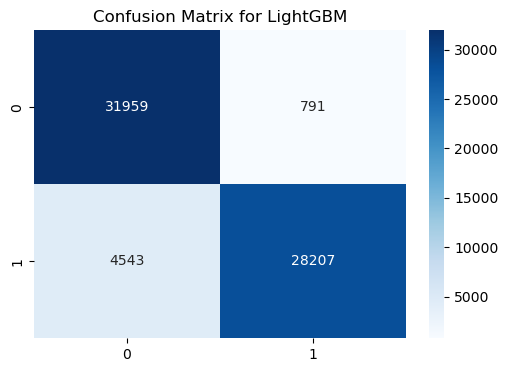

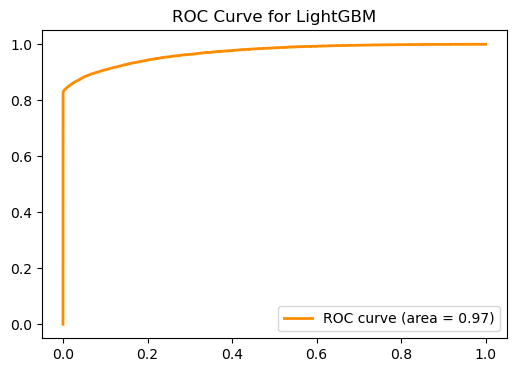

In [10]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Initialize the LightGBM model
lgb_model = LGBMClassifier(random_state=42)

# Step 2: Set up hyperparameter grid for tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}

# Step 3: Perform Grid Search with cross-validation (GridSearchCV)
grid_search_lgb = GridSearchCV(estimator=lgb_model, param_grid=param_grid, 
                               cv=3, verbose=2, n_jobs=-1)

# Step 4: Fit the model to the training data
grid_search_lgb.fit(X_train, y_train)

# Step 5: Use the best estimator from GridSearchCV
best_model_lgb = grid_search_lgb.best_estimator_

# Step 6: Evaluate the model
y_val_pred_lgb = best_model_lgb.predict(X_val)
y_val_prob_lgb = best_model_lgb.predict_proba(X_val)[:, 1]  # For ROC-AUC calculation
lgb_accuracy = accuracy_score(y_val, y_val_pred_lgb)

print(f"Best parameters for LightGBM: {grid_search_lgb.best_params_}")
print(f"LightGBM Accuracy: {lgb_accuracy:.4f}")
print("Classification Report for LightGBM:\n", classification_report(y_val, y_val_pred_lgb))

# Confusion matrix
cm_lgb = confusion_matrix(y_val, y_val_pred_lgb)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_lgb, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix for LightGBM')
plt.show()

# ROC Curve
fpr_lgb, tpr_lgb, _ = roc_curve(y_val, y_val_prob_lgb)
roc_auc_lgb = auc(fpr_lgb, tpr_lgb)
plt.figure(figsize=(6, 4))
plt.plot(fpr_lgb, tpr_lgb, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_lgb:.2f})')
plt.title('ROC Curve for LightGBM')
plt.legend(loc="lower right")
plt.show()

### Decision Tree Classifier for Diabetes Prediction

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best hyperparameters for Decision Tree: {'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': None, 'max_depth': None, 'criterion': 'entropy'}
Best Decision Tree Validation Accuracy: 0.8866259541984732
Best Decision Tree Validation ROC-AUC: 0.9347407018239029
Classification Report for Best Decision Tree:
               precision    recall  f1-score   support

         0.0       0.87      0.91      0.89     32750
         1.0       0.91      0.86      0.88     32750

    accuracy                           0.89     65500
   macro avg       0.89      0.89      0.89     65500
weighted avg       0.89      0.89      0.89     65500



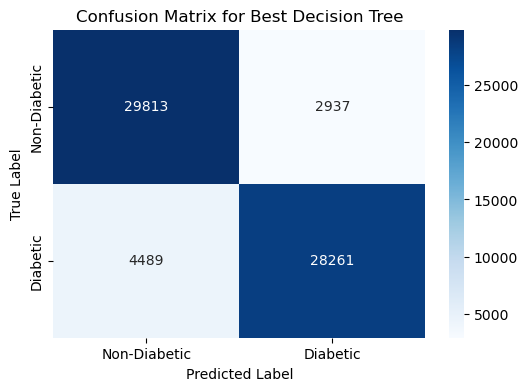

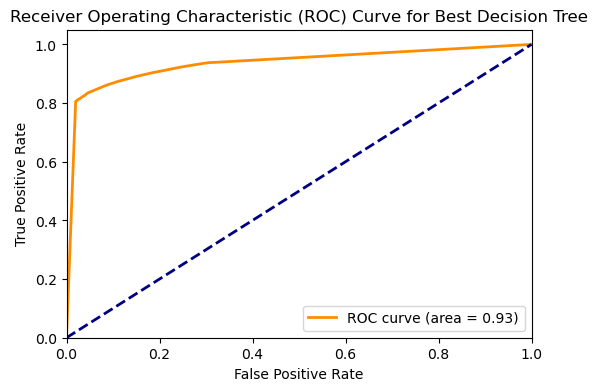

In [24]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Initialize the Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42)

# Step 2: Set up hyperparameter grid for tuning
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10],
    'max_features': [None, 'sqrt', 'log2']
}

# Step 3: Perform Randomized Search with cross-validation (RandomizedSearchCV)
random_search_dt = RandomizedSearchCV(estimator=dt_model, param_distributions=param_grid, 
                                      n_iter=10, cv=3, verbose=2, random_state=42, n_jobs=-1)

# Step 4: Fit the randomized search model to the training data
random_search_dt.fit(X_train, y_train)

# Step 5: Best parameters after search
best_params_dt = random_search_dt.best_params_
print(f"Best hyperparameters for Decision Tree: {best_params_dt}")

# Step 6: Make predictions on the validation set using the best estimator
y_val_pred_dt_best = random_search_dt.best_estimator_.predict(X_val)
y_val_prob_dt_best = random_search_dt.best_estimator_.predict_proba(X_val)[:, 1]  # For ROC-AUC calculation

# Step 7: Evaluate the model
accuracy_dt_best = accuracy_score(y_val, y_val_pred_dt_best)
roc_auc_dt_best = roc_auc_score(y_val, y_val_prob_dt_best)
classification_rep_dt_best = classification_report(y_val, y_val_pred_dt_best)

print(f"Best Decision Tree Validation Accuracy: {accuracy_dt_best}")
print(f"Best Decision Tree Validation ROC-AUC: {roc_auc_dt_best}")
print("Classification Report for Best Decision Tree:\n", classification_rep_dt_best)

# Step 8: Confusion Matrix for the best Decision Tree model
cm_dt_best = confusion_matrix(y_val, y_val_pred_dt_best)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_dt_best, annot=True, fmt="d", cmap="Blues", xticklabels=['Non-Diabetic', 'Diabetic'], yticklabels=['Non-Diabetic', 'Diabetic'])
plt.title('Confusion Matrix for Best Decision Tree')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Step 9: ROC Curve for the best Decision Tree model
fpr_dt_best, tpr_dt_best, _ = roc_curve(y_val, y_val_prob_dt_best)
roc_auc_best = auc(fpr_dt_best, tpr_dt_best)

plt.figure(figsize=(6, 4))
plt.plot(fpr_dt_best, tpr_dt_best, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_best:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Best Decision Tree')
plt.legend(loc="lower right")
plt.show()

### Logistic Regression for Diabetes Prediction

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best parameters for Logistic Regression: {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}
Logistic Regression Accuracy: 0.7509
Classification Report:
               precision    recall  f1-score   support

         0.0       0.76      0.73      0.74     32750
         1.0       0.74      0.78      0.76     32750

    accuracy                           0.75     65500
   macro avg       0.75      0.75      0.75     65500
weighted avg       0.75      0.75      0.75     65500



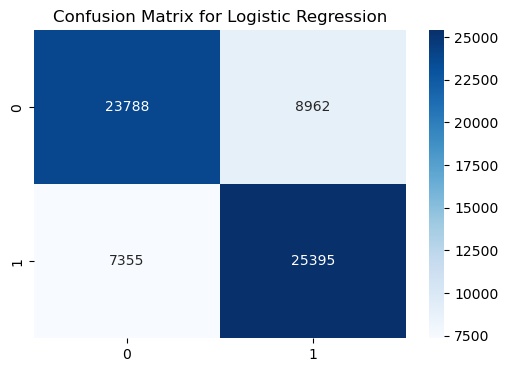

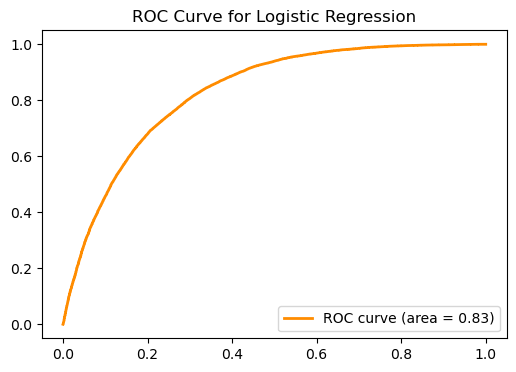

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Initialize the Logistic Regression model
log_reg_model = LogisticRegression(random_state=42)

# Step 2: Set up hyperparameter grid for tuning
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']  # Supports l1/l2 regularization
}

# Step 3: Perform Grid Search with cross-validation (GridSearchCV)
grid_search_logreg = GridSearchCV(estimator=log_reg_model, param_grid=param_grid, 
                                  cv=3, verbose=2, n_jobs=-1)

# Step 4: Fit the model to the training data
grid_search_logreg.fit(X_train, y_train)

# Step 5: Evaluate the model
y_val_pred_logreg = grid_search_logreg.predict(X_val)
y_val_prob_logreg = grid_search_logreg.predict_proba(X_val)[:, 1]  # For ROC-AUC calculation
logreg_accuracy = accuracy_score(y_val, y_val_pred_logreg)


# Step 6: Metrics and confusion matrix
print(f"Best parameters for Logistic Regression: {grid_search_logreg.best_params_}")
print(f"Logistic Regression Accuracy: {logreg_accuracy:.4f}")
print("Classification Report:\n", classification_report(y_val, y_val_pred_logreg))

# Confusion matrix
cm_logreg = confusion_matrix(y_val, y_val_pred_logreg)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_logreg, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix for Logistic Regression')
plt.show()

# ROC Curve
fpr_logreg, tpr_logreg, _ = roc_curve(y_val, y_val_prob_logreg)
roc_auc_logreg = auc(fpr_logreg, tpr_logreg)
plt.figure(figsize=(6, 4))
plt.plot(fpr_logreg, tpr_logreg, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_logreg:.2f})')
plt.title('ROC Curve for Logistic Regression')
plt.legend(loc="lower right")
plt.show()

###  Naive Bayes for Diabetes Prediction

Naive Bayes Accuracy: 0.7226
Classification Report for Naive Bayes:
               precision    recall  f1-score   support

         0.0       0.72      0.73      0.72     32750
         1.0       0.72      0.72      0.72     32750

    accuracy                           0.72     65500
   macro avg       0.72      0.72      0.72     65500
weighted avg       0.72      0.72      0.72     65500



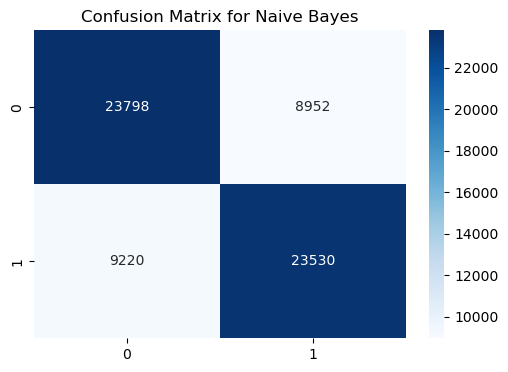

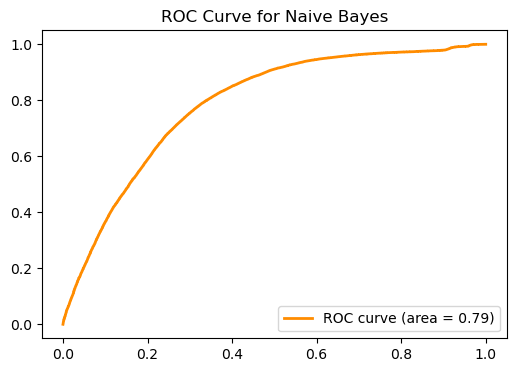

In [26]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Initialize the Naive Bayes model
nb_model = GaussianNB()

# Step 2: Train the model on the training data
nb_model.fit(X_train, y_train)

# Step 3: Evaluate the model
y_val_pred_nb = nb_model.predict(X_val)
y_val_prob_nb = nb_model.predict_proba(X_val)[:, 1]  # For ROC-AUC calculation
nb_accuracy = accuracy_score(y_val, y_val_pred_nb)

print(f"Naive Bayes Accuracy: {nb_accuracy:.4f}")
print("Classification Report for Naive Bayes:\n", classification_report(y_val, y_val_pred_nb))

# Confusion matrix
cm_nb = confusion_matrix(y_val, y_val_pred_nb)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_nb, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix for Naive Bayes')
plt.show()

# ROC Curve
fpr_nb, tpr_nb, _ = roc_curve(y_val, y_val_prob_nb)
roc_auc_nb = auc(fpr_nb, tpr_nb)
plt.figure(figsize=(6, 4))
plt.plot(fpr_nb, tpr_nb, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_nb:.2f})')
plt.title('ROC Curve for Naive Bayes')
plt.legend(loc="lower right")
plt.show()

### Results Comparison of Models

In [34]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Function to compare models
def evaluate_model(name, y_val, y_pred, y_prob):
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    roc_auc = roc_auc_score(y_val, y_prob)
    
    print(f"Model: {name}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")
    print("\n")
    return {
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc
    }

# Evaluate Random Forest, XGBoost, and Decision Tree in addition to previously built models
results = []

# Logistic Regression
results.append(evaluate_model("Logistic Regression", y_val, y_val_pred_logreg, y_val_prob_logreg))

# Naive Bayes
results.append(evaluate_model("Naive Bayes", y_val, y_val_pred_nb, y_val_prob_nb))

# # SVM
# results.append(evaluate_model("SVM", y_val, y_val_pred_svm, y_val_prob_svm))

# LightGBM
results.append(evaluate_model("LightGBM", y_val, y_val_pred_lgb, y_val_prob_lgb))

# Random Forest (already built)
results.append(evaluate_model("Random Forest", y_val, y_val_pred, y_val_prob))

# XGBoost (already built)
results.append(evaluate_model("XGBoost", y_val, y_val_pred_xgb, y_val_prob_xgb))

# Decision Tree (already built)
results.append(evaluate_model("Decision Tree", y_val, y_val_pred_dt_best, y_val_prob_dt_best))

# Create a DataFrame for easier comparison
import pandas as pd
results_df = pd.DataFrame(results)

results_df.head(10)

Model: Logistic Regression
Accuracy: 0.7509
Precision: 0.7392
Recall: 0.7754
F1-Score: 0.7569
ROC-AUC: 0.8278


Model: Naive Bayes
Accuracy: 0.7226
Precision: 0.7244
Recall: 0.7185
F1-Score: 0.7214
ROC-AUC: 0.7872


Model: LightGBM
Accuracy: 0.9186
Precision: 0.9727
Recall: 0.8613
F1-Score: 0.9136
ROC-AUC: 0.9698


Model: Random Forest
Accuracy: 0.9096
Precision: 0.9413
Recall: 0.8736
F1-Score: 0.9062
ROC-AUC: 0.9660


Model: XGBoost
Accuracy: 0.9162
Precision: 0.9707
Recall: 0.8583
F1-Score: 0.9110
ROC-AUC: 0.9690


Model: Decision Tree
Accuracy: 0.8866
Precision: 0.9059
Recall: 0.8629
F1-Score: 0.8839
ROC-AUC: 0.9347




Model  Accuracy  Precision    Recall  F1-Score   ROC-AUC
0  Logistic Regression  0.750885   0.739151  0.775420  0.756851  0.827772
1          Naive Bayes  0.722565   0.724401  0.718473  0.721425  0.787205
2             LightGBM  0.918565   0.972722  0.861282  0.913617  0.969756
3        Random Forest  0.909588   0.941337  0.873618  0.906214  0.966015
4              XGBoost  0.916183   0.970714  0.858260  0.911030  0.968972
5        Decision Tree  0.886626   0.905859  0.862931  0.883874  0.934741

### Visualizing Comparison Between Models

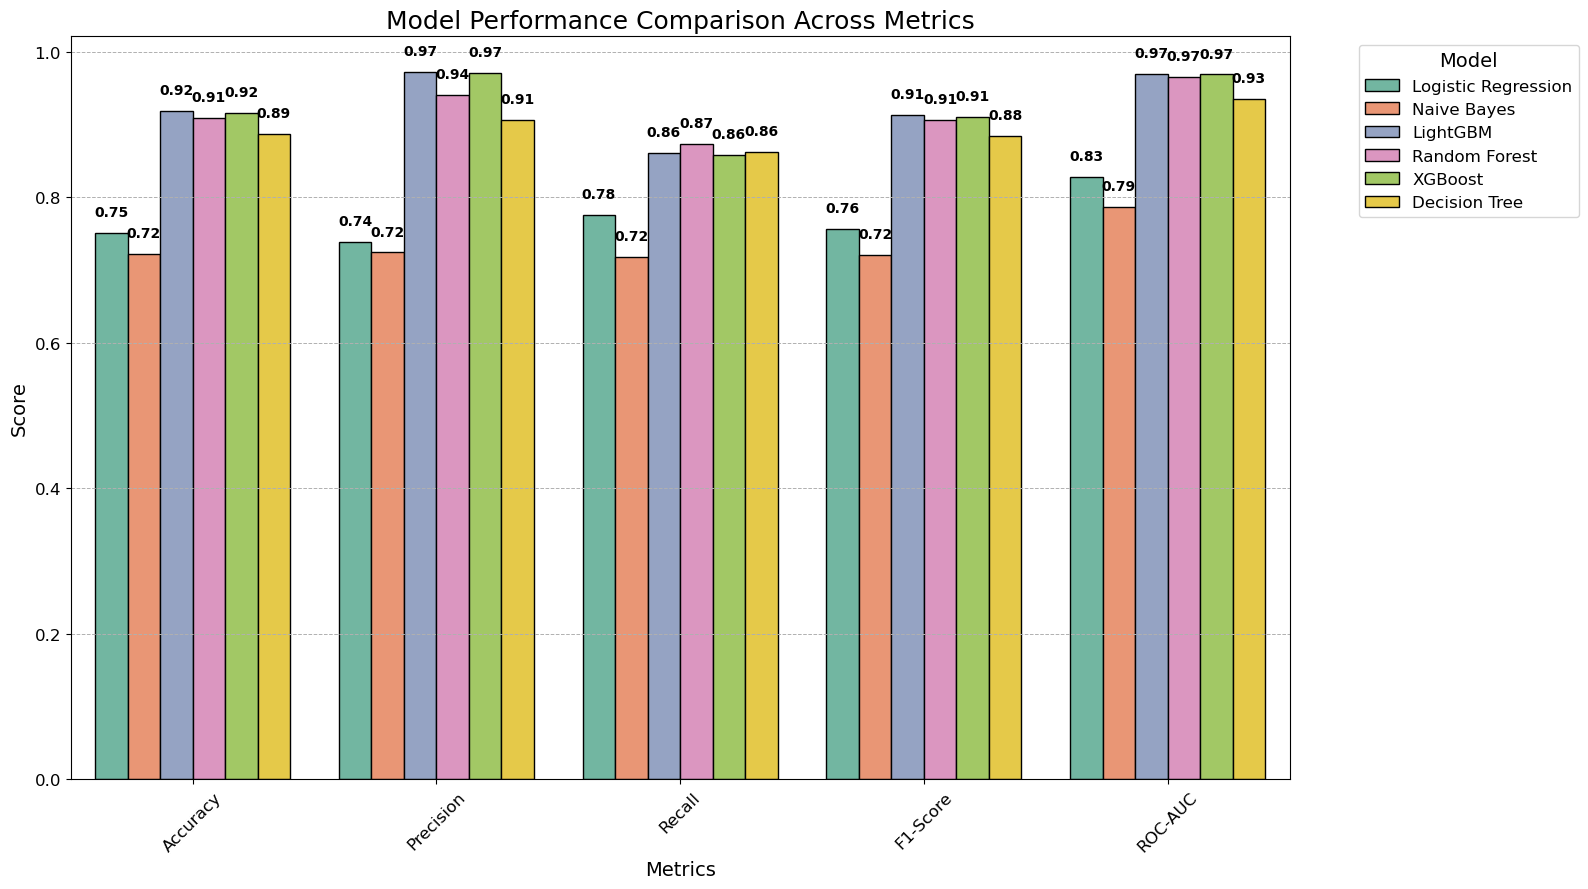

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming results_df is already defined

# Convert the DataFrame to long format for easier plotting
results_long = pd.melt(results_df, id_vars=['Model'], value_vars=['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC'])

# Step 1: Create the figure and adjust size
plt.figure(figsize=(16, 9))

# Step 2: Set a distinct color palette
sns.set_palette("Set2")

# Plot the comparison of the models for each metric
# Increase bar width by setting width=0.9
barplot = sns.barplot(x='variable', y='value', hue='Model', data=results_long, edgecolor='black', width=0.8)  # Increased width

# Step 3: Annotate the bars with values and adjust font size and position
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.2f'),  # Format value to 2 decimal places
                     (p.get_x() + p.get_width() / 2., p.get_height()),  # Coordinates for placing the text
                     ha='center', va='bottom', xytext=(0, 10),  # Adjust the position (0, 10) to place it higher above the bar
                     textcoords='offset points', fontsize=10, fontweight='bold')  # Increased font size and bold

# Step 4: Customize the plot
plt.title('Model Performance Comparison Across Metrics', fontsize=18)
plt.ylabel('Score', fontsize=14)
plt.xlabel('Metrics', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# Step 5: Customize legend placement and font size
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12, title_fontsize=14)

# Add grid for better visibility of values
plt.grid(True, which='major', axis='y', linestyle='--', linewidth=0.7)

# Step 6: Adjust layout and display
plt.tight_layout()
plt.show()


In [51]:
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Split the dataset (if not already split)
# Assuming X_train, X_test, y_train, and y_test are already defined

# Initialize individual models
xgb_model = XGBClassifier(random_state=42)
rf_model = RandomForestClassifier(random_state=42)
lgbm_model = LGBMClassifier(random_state=42)

# Create the VotingClassifier ensemble
ensemble_model = VotingClassifier(estimators=[
    ('xgb', xgb_model),
    ('rf', rf_model),
    ('lgbm', lgbm_model)
], voting='soft')  # Use 'soft' voting for probability-based averaging

# Fit the ensemble model on the training data
ensemble_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = ensemble_model.predict(X_test)
y_prob = ensemble_model.predict_proba(X_test)[:, 1]  # For ROC-AUC calculation

# Evaluate the ensemble model using common metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

# Print the evaluation metrics
print(f"Ensemble Model Accuracy: {accuracy:.4f}")
print(f"Ensemble Model Precision: {precision:.4f}")
print(f"Ensemble Model Recall: {recall:.4f}")
print(f"Ensemble Model F1-Score: {f1:.4f}")
print(f"Ensemble Model ROC-AUC: {roc_auc:.4f}")

[LightGBM] [Info] Number of positive: 152834, number of negative: 152833
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015744 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3960
[LightGBM] [Info] Number of data points in the train set: 305667, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500002 -> initscore=0.000007
[LightGBM] [Info] Start training from score 0.000007
Ensemble Model Accuracy: 0.9221
Ensemble Model Precision: 0.9616
Ensemble Model Recall: 0.8793
Ensemble Model F1-Score: 0.9186
Ensemble Model ROC-AUC: 0.9754


### SHAP (SHapley Additive exPlanations) for LightGBM

C:\Users\Pir Bakhsh\AppData\Roaming\Python\Python311\site-packages\shap\explainers\_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


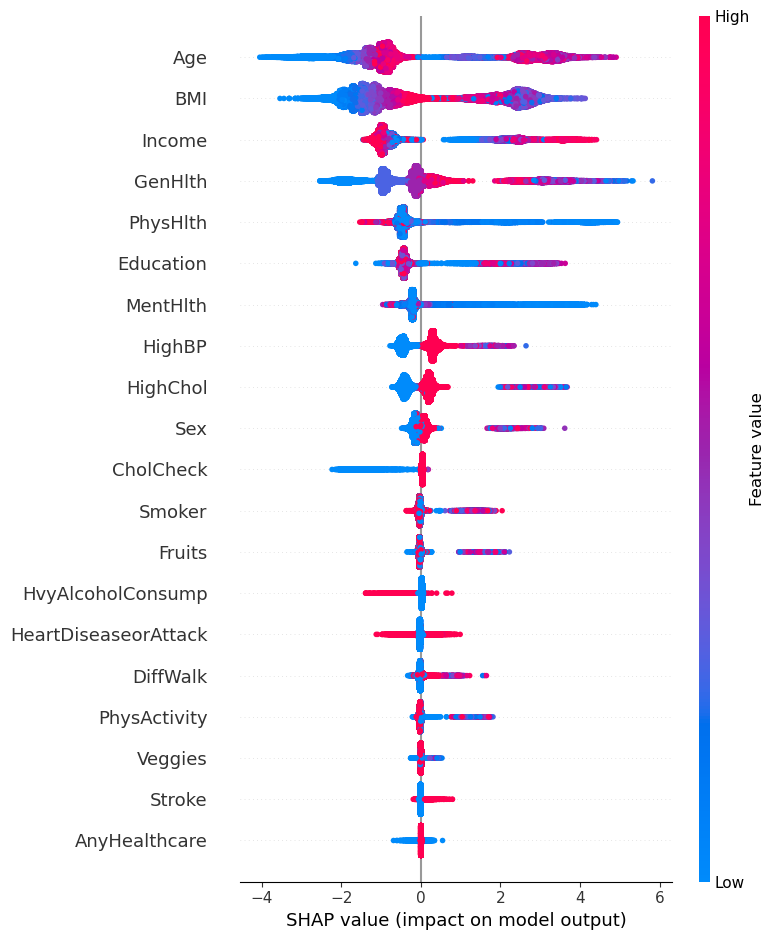

In [11]:
import shap

# Create SHAP explainer for LightGBM model
explainer = shap.TreeExplainer(best_model_lgb)
shap_values = explainer.shap_values(X_test)

# Summary Plot (Global Importance)
shap.summary_plot(shap_values, X_test)

In [14]:
shap.initjs()
# Force Plot (Local Explanation for the first sample)
shap.force_plot(explainer.expected_value, shap_values[0, :], X_test.iloc[0, :])

### Feature Importance (LightGBM Specific Explainability)

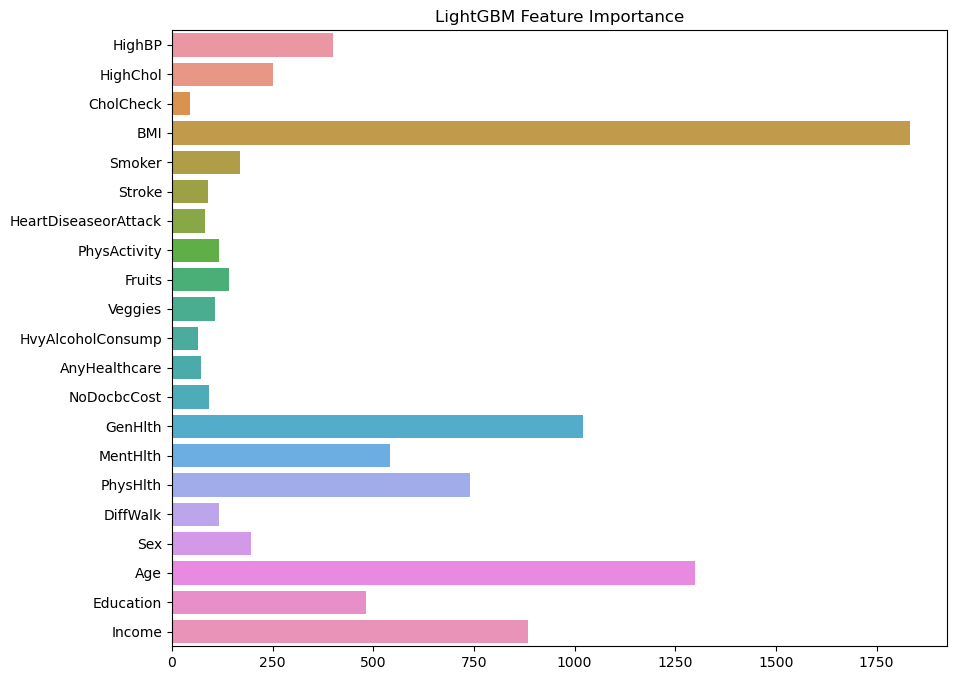

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importance from LightGBM model
importance = best_model_lgb.feature_importances_
features = X_train.columns

# Plot feature importance
plt.figure(figsize=(10, 8))
sns.barplot(x=importance, y=features)
plt.title('LightGBM Feature Importance')
plt.show()

### Partial Dependence Plots (PDP) for LightGBM

In [ ]:
from sklearn.inspection import PartialDependenceDisplay

# Plot Partial Dependence for the most important features
# Replace 0, 1, 2 with the indices of the important features
features = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]  # Example feature indices
PartialDependenceDisplay.from_estimator(best_model_lgb, X_test, features)
plt.show()


### LIME (Local Interpretable Model-agnostic Explanations)

In [18]:
import lime
import lime.lime_tabular

# Initialize LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, 
                                                   feature_names=X_train.columns, 
                                                   class_names=['Non-Diabetic', 'Diabetic'], 
                                                   mode='classification')

# Explain a single prediction (first sample)
exp = explainer.explain_instance(X_test.iloc[0].values, best_model_lgb.predict_proba)
exp.show_in_notebook(show_table=True)

### Explainable Boosting Machine (EBM)

In [19]:
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show

# Train Explainable Boosting Machine
ebm = ExplainableBoostingClassifier()
ebm.fit(X_train, y_train)

# Global Explanations
ebm_global = ebm.explain_global()
show(ebm_global)

# Local Explanations for a single instance
ebm_local = ebm.explain_local(X_test[:5], y_test[:5])
show(ebm_local)

<!-- http://127.0.0.1:7001/1380295469648/ -->

<!-- http://127.0.0.1:7001/1380295878288/ -->

### Global Surrogate Models

In [20]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Train a Decision Tree as a surrogate model on the LightGBM predictions
surrogate = DecisionTreeClassifier(max_depth=3)
surrogate.fit(X_train, best_model_lgb.predict(X_train))

# Predict using the surrogate model
y_pred_surrogate = surrogate.predict(X_test)

# Evaluate the surrogate model
print(f"Surrogate Model Accuracy: {accuracy_score(y_test, y_pred_surrogate)}")

Surrogate Model Accuracy: 0.7422329430085037


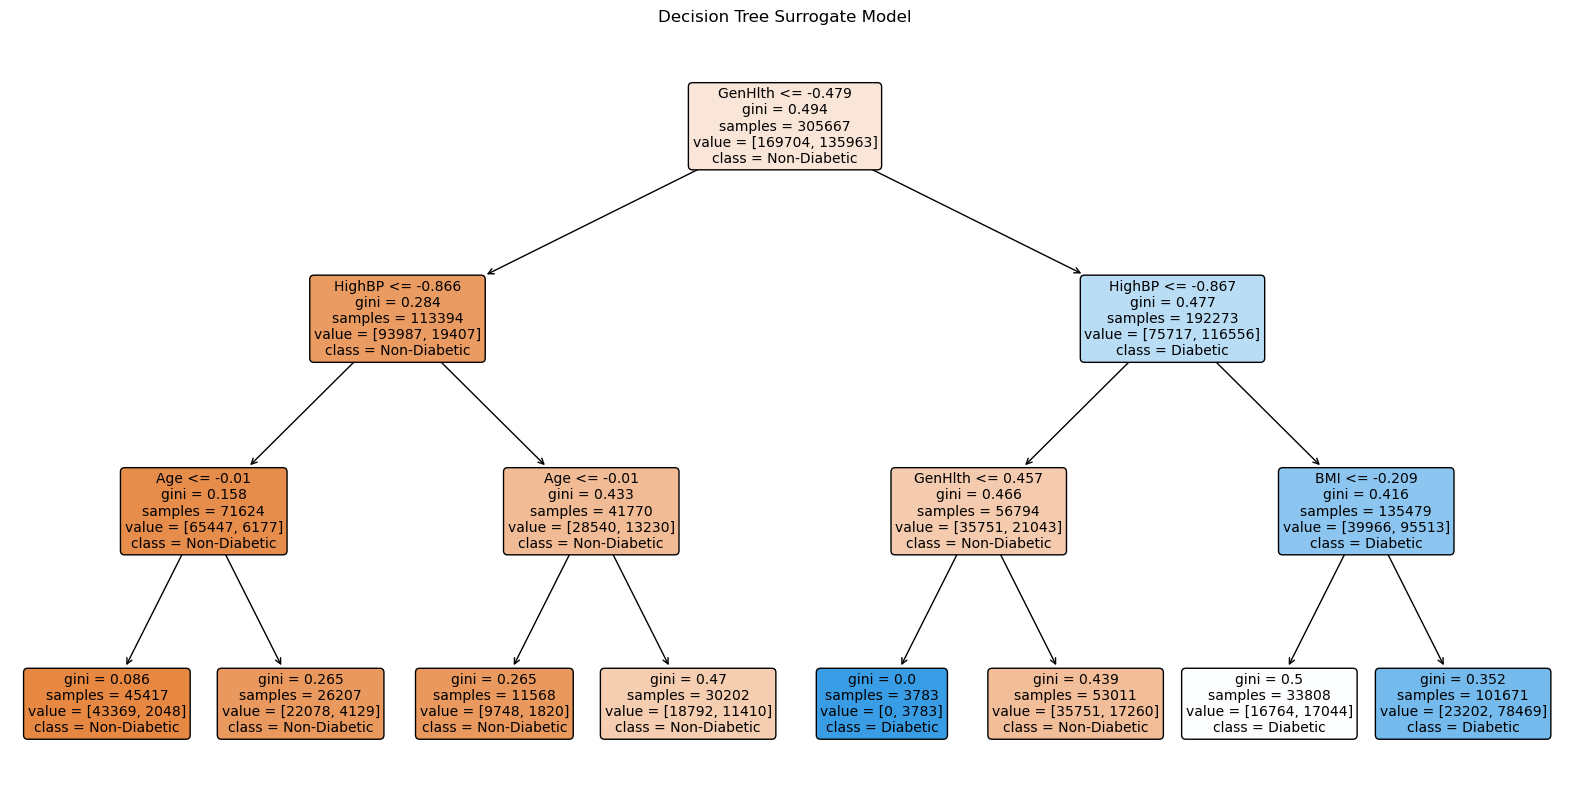

In [26]:
from sklearn import tree
import matplotlib.pyplot as plt

# Convert feature names to a list
feature_names = list(X_train.columns)

# Plot the decision tree
plt.figure(figsize=(20, 10))
tree.plot_tree(surrogate, feature_names=feature_names, filled=True, rounded=True, class_names=['Non-Diabetic', 'Diabetic'])
plt.title("Decision Tree Surrogate Model")
plt.show()

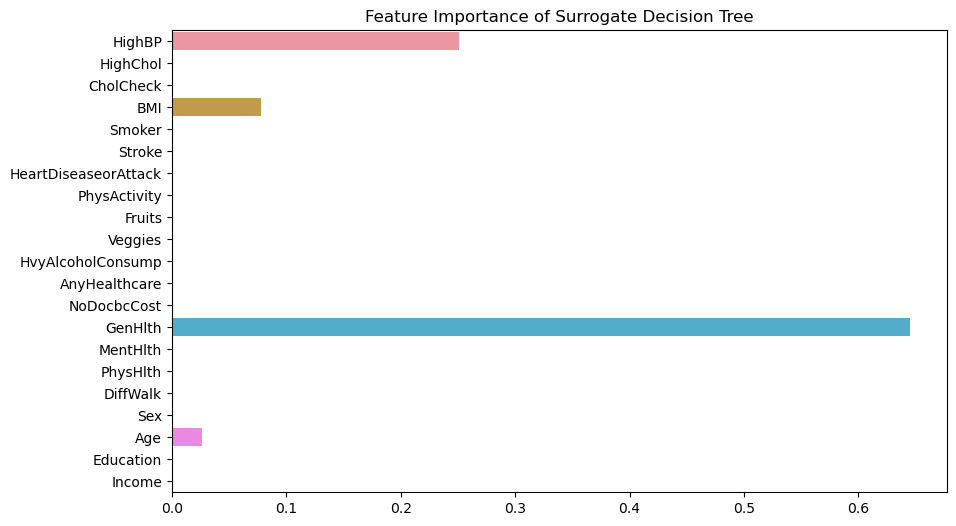

In [27]:
import seaborn as sns

# Get feature importance from the surrogate model
importance = surrogate.feature_importances_
features = X_train.columns

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x=importance, y=features)
plt.title("Feature Importance of Surrogate Decision Tree")
plt.show()

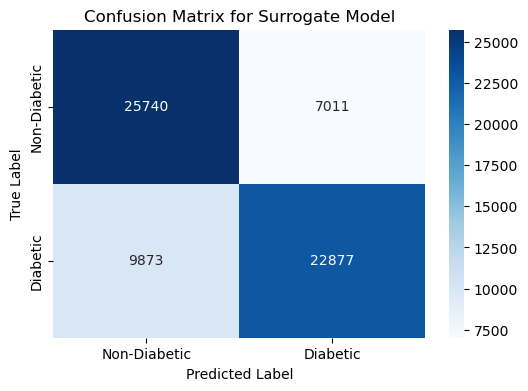

In [28]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_surrogate)

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Non-Diabetic', 'Diabetic'], yticklabels=['Non-Diabetic', 'Diabetic'])
plt.title('Confusion Matrix for Surrogate Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

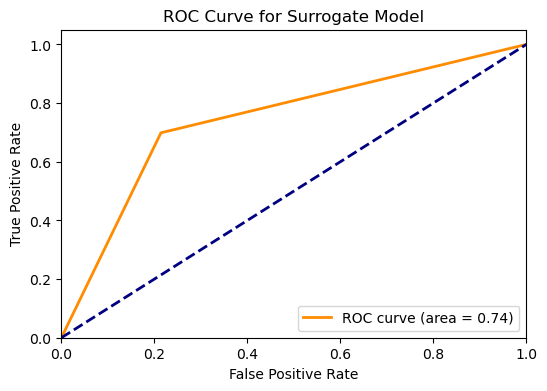

In [29]:
from sklearn.metrics import roc_curve, auc

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_surrogate)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Surrogate Model')
plt.legend(loc="lower right")
plt.show()

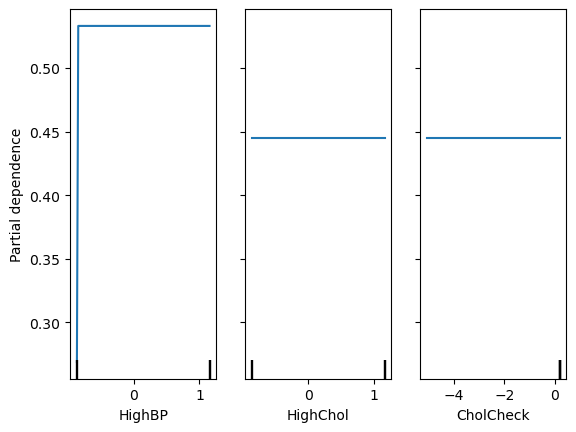

In [30]:
from sklearn.inspection import PartialDependenceDisplay

# Plot Partial Dependence for important features
features = [0, 1, 2]  # Replace with actual indices of important features
PartialDependenceDisplay.from_estimator(surrogate, X_test, features)
plt.show()

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning:

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names



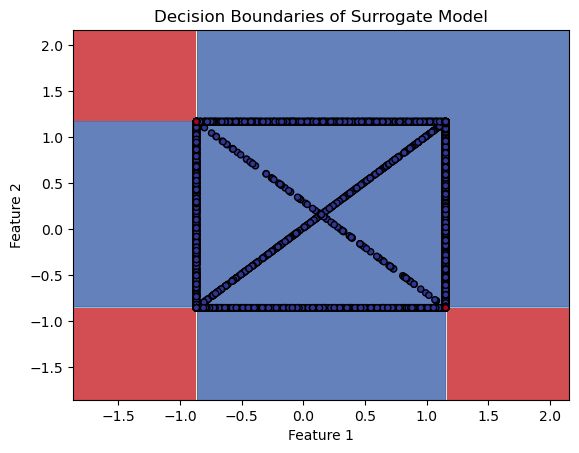

In [31]:
import numpy as np

# Select two features for plotting decision boundaries
X_plot = X_train.iloc[:, [0, 1]]  # Select two important features for visualization

# Train the surrogate on the selected features
surrogate.fit(X_plot, best_model_lgb.predict(X_train))

# Create a meshgrid for plotting decision boundaries
x_min, x_max = X_plot.iloc[:, 0].min() - 1, X_plot.iloc[:, 0].max() + 1
y_min, y_max = X_plot.iloc[:, 1].min() - 1, X_plot.iloc[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

# Predict over the meshgrid
Z = surrogate.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot decision boundaries
plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.RdYlBu)
plt.scatter(X_plot.iloc[:, 0], X_plot.iloc[:, 1], c=y_train, edgecolors='k', marker='o', s=20, cmap=plt.cm.RdYlBu)
plt.title("Decision Boundaries of Surrogate Model")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

### Anchors (Local Explanations)

In [35]:
from alibi.explainers import AnchorTabular
from sklearn.preprocessing import LabelEncoder

# Preprocess the target variable
encoder = LabelEncoder()
y_train_enc = encoder.fit_transform(y_train)

# Initialize the AnchorTabular explainer with the correct 'predictor' argument
explainer = AnchorTabular(predictor=best_model_lgb.predict, feature_names=list(X_train.columns))
explainer.fit(X_train.values)

# Explain an individual instance
explanation = explainer.explain(X_test.iloc[0].values)
print(f'Anchor explanation: {explanation.anchor}')

Could not find an anchor satisfying the 0.95 precision constraint. Now returning the best non-eligible result. The desired precision threshold might not be achieved due to the quantile-based discretisation of the numerical features. The resolution of the bins may be too large to find an anchor of required precision. Consider increasing the number of bins in `disc_perc`, but note that for some numerical distribution (e.g. skewed distribution) it may not help.


Anchor explanation: ['HeartDiseaseorAttack <= -0.32', 'PhysHlth <= -0.49', 'Age <= 0.32', '0.08 < BMI <= 0.70', '-0.05 < Education <= 0.96', 'Income <= -0.99', 'DiffWalk <= -0.45', 'NoDocbcCost <= -0.30', '-0.43 < MentHlth <= -0.16', '-1.76 < PhysActivity <= 0.57', 'Stroke <= -0.21', 'Smoker <= -0.89', 'HighBP <= 1.15', 'AnyHealthcare <= 0.23', 'Veggies <= 0.48', 'CholCheck <= 0.20', '-0.89 < Sex <= 1.13', 'Fruits <= -1.32', 'HighChol <= 1.17', 'HvyAlcoholConsump <= -0.24']


In [36]:
print(f'Precision: {explanation.precision}')
print(f'Coverage: {explanation.coverage}')

# If you want to see all the raw data of the explanation
print(explanation)

Precision: 0.8065268065268065
Coverage: 0.0
Explanation(meta={
  'name': 'AnchorTabular',
  'type': ['blackbox'],
  'explanations': ['local'],
  'params': {
              'seed': None,
              'disc_perc': (25, 50, 75),
              'threshold': 0.95,
              'delta': 0.1,
              'tau': 0.15,
              'batch_size': 100,
              'coverage_samples': 10000,
              'beam_size': 1,
              'stop_on_first': False,
              'max_anchor_size': None,
              'min_samples_start': 100,
              'n_covered_ex': 10,
              'binary_cache_size': 10000,
              'cache_margin': 1000,
              'verbose': False,
              'verbose_every': 1,
              'kwargs': {}}
            ,
  'version': '0.9.6'}
, data={
  'anchor': ['HeartDiseaseorAttack <= -0.32', 'PhysHlth <= -0.49', 'Age <= 0.32', '0.08 < BMI <= 0.70', '-0.05 < Education <= 0.96', 'Income <= -0.99', 'DiffWalk <= -0.45', 'NoDocbcCost <= -0.30', '-0.43 < MentHlth

In [39]:
# Loop through and explain multiple instances (e.g., first 5 instances)
for i in range(5):
    instance = X_test.iloc[i].values
    explanation = explainer.explain(instance)
    
    print(f"\nInstance {i+1}")
    print(f"Anchor explanation: {explanation.anchor}")
    print(f"Precision: {explanation.precision}")
    print(f"Coverage: {explanation.coverage}")

    # Print out the predicted label and true label for comparison
    predicted_label = best_model_lgb.predict([instance])[0]  # Extract the single prediction
    true_label = y_test.iloc[i]
    print(f"Predicted Label: {predicted_label}")
    print(f"True Label: {true_label}")
    
    # Optionally, explore the raw explanation data for further details
    print(f"Raw explanation data: {explanation.raw}")


Could not find an anchor satisfying the 0.95 precision constraint. Now returning the best non-eligible result. The desired precision threshold might not be achieved due to the quantile-based discretisation of the numerical features. The resolution of the bins may be too large to find an anchor of required precision. Consider increasing the number of bins in `disc_perc`, but note that for some numerical distribution (e.g. skewed distribution) it may not help.



Instance 1
Anchor explanation: ['NoDocbcCost <= -0.30', 'PhysHlth <= -0.49', 'Age <= 0.32', 'BMI <= 0.70', 'DiffWalk <= -0.45', 'Smoker <= -0.89', 'PhysActivity <= 0.57', 'CholCheck <= 0.20', 'HighBP <= 1.15', 'Education <= 0.96', 'Sex <= 1.13', 'HighChol <= 1.17', 'Veggies <= 0.48', 'Fruits <= 0.76', 'Income <= 0.94', 'AnyHealthcare <= 0.23']
Precision: 0.8703703703703703
Coverage: 0.1336
Predicted Label: 0.0
True Label: 0.0
Raw explanation data: {'feature': [12, 15, 18, 3, 16, 4, 7, 2, 0, 19, 17, 1, 9, 8, 20, 11], 'mean': [0.564742305590967, 0.6997561825148032, 0.8081504702194358, 0.853010164190774, 0.8615384615384616, 0.8703703703703703, 0.8703703703703703, 0.8703703703703703, 0.8703703703703703, 0.8703703703703703, 0.8703703703703703, 0.8703703703703703, 0.8703703703703703, 0.8703703703703703, 0.8703703703703703, 0.8703703703703703, 0.8703703703703703, 0.8703703703703703, 0.8703703703703703, 0.8703703703703703], 'precision': [0.564742305590967, 0.6997561825148032, 0.80815047021943

Could not find an anchor satisfying the 0.95 precision constraint. Now returning the best non-eligible result. The desired precision threshold might not be achieved due to the quantile-based discretisation of the numerical features. The resolution of the bins may be too large to find an anchor of required precision. Consider increasing the number of bins in `disc_perc`, but note that for some numerical distribution (e.g. skewed distribution) it may not help.



Instance 2
Anchor explanation: ['GenHlth > 0.46', 'PhysHlth > 0.09', '-0.99 < Income <= -0.03', '-0.89 < Sex <= 1.13', '-1.07 < Education <= -0.05', 'NoDocbcCost > -0.30', 'HvyAlcoholConsump <= -0.24', 'CholCheck <= 0.20', '-0.89 < Smoker <= 1.12', 'Veggies <= 0.48', 'Fruits <= -1.32', 'DiffWalk <= 2.22', '-1.76 < PhysActivity <= 0.57', 'HighBP <= 1.15', 'AnyHealthcare <= 0.23', 'HighChol <= -0.86', 'Stroke <= -0.21', 'MentHlth <= -0.16', 'HeartDiseaseorAttack <= -0.32', 'BMI <= 0.08']
Precision: 0.9416909620991254
Coverage: 0.0
Predicted Label: 1.0
True Label: 1.0
Raw explanation data: {'feature': [13, 15, 20, 17, 19, 12, 10, 2, 4, 9, 8, 16, 7, 0, 11, 1, 5, 14, 6, 3], 'mean': [0.6505198487712666, 0.7474747474747475, 0.7619047619047619, 0.7814625850340136, 0.8005093378607809, 0.8306538049303323, 0.8637110016420362, 0.8740740740740741, 0.8787096774193548, 0.8787096774193548, 0.8969957081545065, 0.9140969162995595, 0.9140969162995595, 0.9140969162995595, 0.9140969162995595, 0.9140969162


Instance 3
Anchor explanation: ['Age > 0.32', 'BMI > 0.70', 'HeartDiseaseorAttack > -0.32', 'HighBP > -0.87', 'GenHlth > -0.48']
Precision: 0.9664179104477612
Coverage: 0.0233
Predicted Label: 1.0
True Label: 1.0
Raw explanation data: {'feature': [18, 3, 6, 0, 13], 'mean': [0.6612466124661247, 0.8213213213213213, 0.898854961832061, 0.9486404833836858, 0.9664179104477612], 'precision': [0.6612466124661247, 0.8213213213213213, 0.898854961832061, 0.9486404833836858, 0.9664179104477612], 'coverage': [0.4637, 0.1005, 0.0273, 0.0254, 0.0233], 'examples': [{'covered_true': array([[ 1.15368814,  1.16525449,  0.19692156,  2.6824971 ,  1.12092719,
         4.86294875,  3.10118294,  0.56727485,  0.75937543, -0.48416619,
        -0.24401415,  0.22686264,  3.29844532,  2.32912057,  0.07705222,
         2.73781045,  2.22361507, -0.88702088,  0.55950158, -1.69659877,
        -2.44013754],
       [ 1.15368814,  1.16525449,  0.19692156,  0.56600905,  1.12092719,
        -0.20563655, -0.3224576 , -0.45

Could not find an anchor satisfying the 0.95 precision constraint. Now returning the best non-eligible result. The desired precision threshold might not be achieved due to the quantile-based discretisation of the numerical features. The resolution of the bins may be too large to find an anchor of required precision. Consider increasing the number of bins in `disc_perc`, but note that for some numerical distribution (e.g. skewed distribution) it may not help.



Instance 4
Anchor explanation: ['Stroke <= -0.21', 'GenHlth <= -0.48', 'Age <= 0.90', 'HeartDiseaseorAttack <= -0.32', '-1.32 < Fruits <= 0.76', '-1.76 < PhysActivity <= 0.57', '-0.99 < Income <= 0.94', '-1.07 < Education <= 0.96', 'PhysHlth <= 0.09', 'HighChol <= 1.17', 'HighBP <= 1.15', 'Veggies <= 0.48', 'Smoker <= 1.12', 'AnyHealthcare <= 0.23', 'Sex <= 1.13']
Precision: 0.8917700112739572
Coverage: 0.1268
Predicted Label: 0.0
True Label: 1.0
Raw explanation data: {'feature': [5, 13, 18, 6, 8, 7, 20, 19, 15, 1, 0, 9, 4, 11, 17], 'mean': [0.5712038890477552, 0.8492786636294609, 0.8716603053435115, 0.87744140625, 0.8823529411764706, 0.8862876254180602, 0.8903225806451613, 0.8913043478260869, 0.8917700112739572, 0.8917700112739572, 0.8917700112739572, 0.8917700112739572, 0.8917700112739572, 0.8917700112739572, 0.8917700112739572, 0.8917700112739572, 0.8917700112739572, 0.8917700112739572, 0.8917700112739572, 0.8917700112739572], 'precision': [0.5712038890477552, 0.8492786636294609, 0


Instance 5
Anchor explanation: ['Age > 0.32', 'GenHlth > 0.46', 'BMI > 0.70', 'HighBP > -0.87', 'MentHlth > -0.43']
Precision: 0.973404255319149
Coverage: 0.0221
Predicted Label: 1.0
True Label: 1.0
Raw explanation data: {'feature': [18, 13, 3, 0, 14], 'mean': [0.6560236998025016, 0.8208154506437768, 0.9050279329608939, 0.9498327759197325, 0.973404255319149], 'precision': [0.6560236998025016, 0.8208154506437768, 0.9050279329608939, 0.9498327759197325, 0.973404255319149], 'coverage': [0.4526, 0.156, 0.0494, 0.0455, 0.0221], 'examples': [{'covered_true': array([[ 1.15368814,  1.16525449,  0.19692156,  0.86225881,  1.12092719,
        -0.20563655, -0.3224576 ,  0.56727485, -1.31687168,  0.48208665,
        -0.24401415,  0.22686264, -0.30317313,  1.39320746, -0.42962961,
        -0.48659241, -0.44971813, -0.88702088,  1.62656583, -1.08607533,
        -0.52833304],
       [ 1.15368814,  0.18580067,  0.19692156, -1.41487731,  1.12092719,
        -0.20563655, -0.3224576 ,  0.56727485, -1.316

In [41]:
pip install tensorflow-probability

Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for tensorflow-probability from https://files.pythonhosted.org/packages/6c/c9/93e9e34703269d5ec3f6a8f49f6748df8737fede8bb1f34165f6ef3d861b/tensorflow_probability-0.24.0-py2.py3-none-any.whl.metadata
  Obtaining dependency information for dm-tree from https://files.pythonhosted.org/packages/e4/c1/522041457444b67125ac9527208bb3148f63d7dce0a86ffa589ec763a10e/dm_tree-0.1.8-cp311-cp311-win_amd64.whl.metadata
   ---------------------------------------- 0.0/6.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/6.9 MB 682.7 kB/s eta 0:00:11
    --------------------------------------- 0.1/6.9 MB 1.3 MB/s eta 0:00:06
   --- ------------------------------------ 0.6/6.9 MB 5.2 MB/s eta 0:00:02
   -------- ------------------------------- 1.4/6.9 MB 8.9 MB/s eta 0:00:01
   ------------ --------------------------- 2.1/6.9 MB 10.3 MB/s eta 0:00:01
   ---------------- --------

### Counterfactual Explanations

In [51]:
from alibi.explainers import CounterfactualProto
import numpy as np

# Define the prediction function (probability output)
predict_fn = lambda x: best_model_lgb.predict_proba(x.reshape(1, -1) if x.ndim == 1 else x)

# Feature range (use the min and max values from the training data for each feature)
feature_range = (X_train.min(axis=0).values, X_train.max(axis=0).values)

# Initialize the CounterfactualProto explainer
cf_proto = CounterfactualProto(predict_fn, shape=(1, X_test.shape[1]), gamma=1.0, feature_range=feature_range)

# Fit the explainer on the training data
cf_proto.fit(X_train.values, d_type='abdm')

# Reshape the input instance to 2D (1 sample, n features)
instance = X_test.iloc[0].values.reshape(1, -1)

# Generate counterfactual explanation for the reshaped instance
cf_explanation = cf_proto.explain(instance)

# Extract the counterfactual instance
counterfactual_instance = cf_explanation.cf['X']

# Print the counterfactual result
print("Counterfactual instance:")
print(counterfactual_instance)

# Calculate the distance between the original instance and the counterfactual
distance = np.linalg.norm(instance - counterfactual_instance)
print(f"Counterfactual distance: {distance}")

Counterfactual instance:
[[ 1.1536882   1.1652545   0.19692156  0.24477446 -0.89211863 -0.20563655
  -0.3224576   0.56727487 -1.3168716  -2.0743158  -0.24401414  0.22686264
  -0.30317312  1.3932074  -0.15982719 -0.48646092 -0.44971812  1.1273692
  -0.01051636  0.96327156 -2.4401376 ]]
Counterfactual distance: 0.00013148575203612034


In [52]:
# If your features are standardized, inverse the transformation
# Assuming you have a scaler, e.g., from sklearn.preprocessing
counterfactual_original = scaler.inverse_transform(counterfactual_instance)
original_instance_original = scaler.inverse_transform(instance)

# Check the differences between the original and counterfactual instances
changes = counterfactual_original - original_instance_original
print("Feature changes required to achieve counterfactual:")
print(changes)

Feature changes required to achieve counterfactual:
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -2.17178204e-08  2.31952479e-09 -2.60147681e-09  0.00000000e+00
  -1.15863461e-08  5.44580808e-08  6.11130868e-10  0.00000000e+00
   2.89564661e-09  0.00000000e+00  0.00000000e+00  1.14620198e-03
   7.78187381e-09  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]]


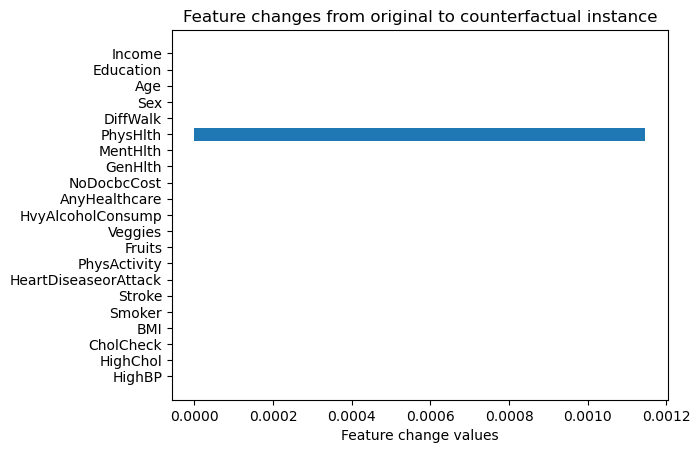

In [53]:
import matplotlib.pyplot as plt

feature_names = X_train.columns  # Assuming feature names are available
plt.barh(feature_names, changes.flatten())
plt.xlabel("Feature change values")
plt.title("Feature changes from original to counterfactual instance")
plt.show()

In [54]:
# Predict the label for the counterfactual instance
prediction_cf = best_model_lgb.predict(counterfactual_instance)
print(f"Prediction for counterfactual instance: {prediction_cf}")

Prediction for counterfactual instance: [1.]


In [55]:
# Example check: Ensure that all features are within feasible bounds
for i, value in enumerate(counterfactual_original.flatten()):
    if value < feature_range[0][i] or value > feature_range[1][i]:
        print(f"Feature {feature_names[i]} has an unrealistic value: {value}")

Feature CholCheck has an unrealistic value: 1.0
Feature BMI has an unrealistic value: 30.0
Feature PhysActivity has an unrealistic value: 1.0
Feature AnyHealthcare has an unrealistic value: 1.0
Feature GenHlth has an unrealistic value: 4.0
Feature Age has an unrealistic value: 8.0
Feature Education has an unrealistic value: 6.0
Feature Income has an unrealistic value: 1.0


In [56]:
# Try adjusting the gamma parameter for a sparser counterfactual
cf_proto = CounterfactualProto(predict_fn, shape=(1, X_test.shape[1]), gamma=0.5, feature_range=feature_range)
cf_proto.fit(X_train.values, d_type='abdm')
cf_explanation = cf_proto.explain(instance)

In [57]:
perturbation = np.random.normal(0, 0.01, counterfactual_instance.shape)
perturbed_instance = counterfactual_instance + perturbation
prediction_perturbed = best_model_lgb.predict(perturbed_instance)
print(f"Prediction after perturbation: {prediction_perturbed}")

Prediction after perturbation: [1.]


In [60]:
for i in range(5):
    instance = X_test.iloc[i].values.reshape(1, -1)
    cf_explanation = cf_proto.explain(instance)
    
    if cf_explanation.cf is None:
        print(f"No counterfactual found for instance {i+1}.")
    else:
        counterfactual_instance = cf_explanation.cf['X']
        print(f"Instance {i+1}: Counterfactual")
        print(counterfactual_instance)

Instance 1: Counterfactual
[[ 1.1536882   1.1652545   0.19692156  0.24477446 -0.89211863 -0.20563655
  -0.3224576   0.56727487 -1.3168716  -2.0743158  -0.24401414  0.22686264
  -0.30317312  1.3932074  -0.15982719 -0.48646092 -0.44971812  1.1273692
  -0.01051636  0.96327156 -2.4401376 ]]


No counterfactual found!


No counterfactual found for instance 2.


No counterfactual found!


No counterfactual found for instance 3.
Instance 4: Counterfactual
[[ 1.1536882   1.1652545   0.19692156  2.211884    1.1209272  -0.20563655
  -0.3224576   0.56727487  0.75937545  0.48208666 -0.24401414  0.22686264
  -0.30317312 -0.47861877 -0.42958575  0.08693796  2.2236152   1.1273692
   0.6443165  -0.05116153 -0.5088372 ]]


No counterfactual found!


No counterfactual found for instance 5.


In [61]:
import shap
explainer = shap.TreeExplainer(best_model_lgb)
shap_values_cf = explainer.shap_values(counterfactual_instance)
shap.force_plot(explainer.expected_value, shap_values_cf, counterfactual_instance)

C:\Users\Pir Bakhsh\AppData\Roaming\Python\Python311\site-packages\shap\explainers\_tree.py:448: UserWarning:

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray



In [66]:
# Fidelity: Compare the predictions of the surrogate model and the original model
y_pred_original = best_model_lgb.predict(X_test)
fidelity = accuracy_score(y_pred_original, y_pred_surrogate)
print(f"Fidelity Score: {fidelity}")

Fidelity Score: 0.7482175844643594


In [71]:
import shap
import numpy as np

# Use SHAP to explain the model's predictions
explainer = shap.TreeExplainer(best_model_lgb)
shap_values = explainer.shap_values(X_test)

# Perturbation-based faithfulness measurement
def faithfulness_score(model, X, shap_values):
    faithfulness = 0
    for i in range(X.shape[1]):  # Loop over each feature
        X_perturbed = X.copy()
        X_perturbed.iloc[:, i] = np.mean(X.iloc[:, i])  # Perturb the feature by replacing it with its mean
        pred_original = model.predict_proba(X)[:, 1]  # Get original predictions
        pred_perturbed = model.predict_proba(X_perturbed)[:, 1]  # Get predictions with perturbed feature
        change_in_pred = np.abs(pred_original - pred_perturbed)
        faithfulness += np.mean(change_in_pred)
    return faithfulness / X.shape[1]

faithfulness = faithfulness_score(best_model_lgb, X_test, shap_values)
print(f"Faithfulness Score: {faithfulness}")

C:\Users\Pir Bakhsh\AppData\Roaming\Python\Python311\site-packages\shap\explainers\_tree.py:448: UserWarning:

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray



Faithfulness Score: 0.154474210139357


In [72]:
# Compute sparsity for a counterfactual explanation
def sparsity_score(original_instance, counterfactual_instance):
    return np.sum(original_instance == counterfactual_instance) / len(original_instance)

# Example of using this with counterfactuals
original_instance = X_test.iloc[0].values
# Assuming you already generated a counterfactual instance, compare the two
sparsity = sparsity_score(original_instance, counterfactual_instance)
print(f"Sparsity Score: {sparsity}")

Sparsity Score: 0.0


In [73]:
# Stability: Measure how much predictions change when the input is perturbed slightly
def stability_score(model, X, perturbation_amount=0.01, n_perturbations=10):
    predictions = []
    for _ in range(n_perturbations):
        X_perturbed = X + np.random.normal(0, perturbation_amount, X.shape)
        predictions.append(model.predict(X_perturbed))
    predictions = np.array(predictions)
    variance = np.var(predictions, axis=0)
    return np.mean(variance)

stability = stability_score(best_model_lgb, X_test)
print(f"Stability Score: {stability}")

Stability Score: 2.1984397184775803e-05


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Increase the depth of the surrogate model to improve fidelity
surrogate = DecisionTreeClassifier(max_depth=7)  # Increased from 3 to 5
surrogate.fit(X_train, best_model_lgb.predict(X_train))

# Predict using the surrogate model
y_pred_surrogate = surrogate.predict(X_test)

# Measure fidelity
y_pred_original = best_model_lgb.predict(X_test)
fidelity = accuracy_score(y_pred_original, y_pred_surrogate)
print(f"Improved Fidelity Score: {fidelity}")

In [ ]:
from alibi.explainers import CounterfactualProto

# Define the prediction function (probability output)
predict_fn = lambda x: best_model_lgb.predict_proba(x)

# Feature range (use the min and max values from the training data for each feature)
feature_range = (X_train.min(axis=0).values, X_train.max(axis=0).values)

# Initialize the CounterfactualProto explainer with adjusted gamma for sparsity
cf_proto = CounterfactualProto(predict_fn, shape=(1, X_test.shape[1]), gamma=0.1, feature_range=feature_range)

# Fit the explainer on the training data
cf_proto.fit(X_train.values, d_type='abdm')

# Generate counterfactual explanation for an instance
instance = X_test.iloc[0].values.reshape(1, -1)
cf_explanation = cf_proto.explain(instance)

# Calculate sparsity if a counterfactual is found
if cf_explanation.cf is not None:
    counterfactual_instance = cf_explanation.cf['X']
    sparsity = np.sum(instance == counterfactual_instance) / instance.size
    print(f"Improved Sparsity Score: {sparsity}")
else:
    print("No counterfactual found.")

In [77]:
# Stability: Perturb the most important features slightly and observe the variance in predictions
def stability_score(model, X, important_features, perturbation_amount=0.01, n_perturbations=10):
    predictions = []
    for _ in range(n_perturbations):
        X_perturbed = X.copy()
        X_perturbed.iloc[:, important_features] += np.random.normal(0, perturbation_amount, X_perturbed.iloc[:, important_features].shape)
        predictions.append(model.predict(X_perturbed))
    predictions = np.array(predictions)
    variance = np.var(predictions, axis=0)
    return np.mean(variance)

# Get the indices of the most important features based on SHAP
important_features = np.argsort(np.abs(shap_values).mean(0))[-5:]  # Top 5 important features

stability = stability_score(best_model_lgb, X_test, important_features)
print(f"Improved Stability Score: {stability}")

Improved Stability Score: 0.001854017495916093


In [82]:
import shap
import numpy as np

# Assuming best_model_lgb is your trained LightGBM model
explainer = shap.TreeExplainer(best_model_lgb)

# Step 1: Split the data into multiple subsets
X_subset_1 = X_test.iloc[:len(X_test) // 2]
X_subset_2 = X_test.iloc[len(X_test) // 2:]

# Step 2: Compute SHAP values for each subset
shap_values_subset_1 = explainer.shap_values(X_subset_1)
shap_values_subset_2 = explainer.shap_values(X_subset_2)

# Step 3: Ensure the subsets have the same number of rows
min_rows = min(shap_values_subset_1.shape[0], shap_values_subset_2.shape[0])

# Trim the larger subset to match the size of the smaller one
shap_values_subset_1 = shap_values_subset_1[:min_rows]
shap_values_subset_2 = shap_values_subset_2[:min_rows]

# Step 4: Define the consistency score function (absolute difference in SHAP values)
def consistency_score(shap_values_1, shap_values_2):
    return np.mean(np.abs(shap_values_1 - shap_values_2))

# Step 5: Calculate consistency between the SHAP values of the two subsets
consistency_lgb = consistency_score(shap_values_subset_1, shap_values_subset_2)
print(f"Consistency Score within LightGBM (across data subsets): {consistency_lgb}")

C:\Users\Pir Bakhsh\AppData\Roaming\Python\Python311\site-packages\shap\explainers\_tree.py:448: UserWarning:

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray



Consistency Score within LightGBM (across data subsets): 0.5226899467026217


C:\Users\Pir Bakhsh\AppData\Roaming\Python\Python311\site-packages\shap\explainers\_tree.py:448: UserWarning:

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray



C:\Users\Pir Bakhsh\AppData\Roaming\Python\Python311\site-packages\shap\explainers\_tree.py:448: UserWarning:

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray



Improved Faithfulness Score (Percentile Perturbation): 0.024131337192179567
Improved Faithfulness Score (Interaction Perturbation): 0.04514847887388422


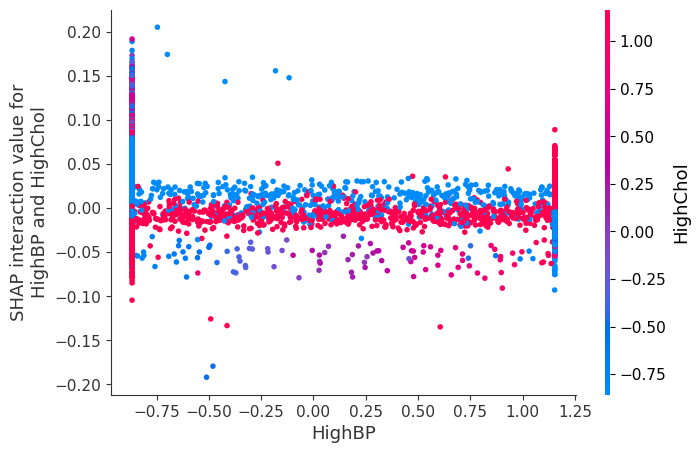

In [80]:
import shap
import numpy as np

# Assuming you already have a trained LightGBM model (best_model_lgb) and SHAP values
explainer = shap.TreeExplainer(best_model_lgb)
shap_values = explainer.shap_values(X_test)

# Step 1: Faithfulness score using percentile-based perturbations
def faithfulness_score_percentile(model, X, shap_values):
    faithfulness = 0
    for i in range(X.shape[1]):  # Loop over each feature
        X_perturbed = X.copy()
        # Perturb feature to its 10th percentile
        X_perturbed.iloc[:, i] = X_perturbed.iloc[:, i].quantile(0.1)
        pred_original = model.predict_proba(X)[:, 1]  # Get original predictions
        pred_perturbed = model.predict_proba(X_perturbed)[:, 1]  # Get predictions with perturbed feature
        change_in_pred = np.abs(pred_original - pred_perturbed)
        faithfulness += np.mean(change_in_pred)
    return faithfulness / X.shape[1]

faithfulness = faithfulness_score_percentile(best_model_lgb, X_test, shap_values)
print(f"Improved Faithfulness Score (Percentile Perturbation): {faithfulness}")

# Step 2: SHAP interaction values (interaction-aware perturbations)
shap_interaction_values = explainer.shap_interaction_values(X_test)

# Faithfulness score based on perturbing pairs of interacting features
def faithfulness_score_interaction(model, X, shap_interaction_values):
    faithfulness = 0
    for i in range(X.shape[1]):  # Loop over each feature
        for j in range(i + 1, X.shape[1]):  # Perturb feature pairs
            X_perturbed = X.copy()
            X_perturbed.iloc[:, i] = X_perturbed.iloc[:, i].quantile(0.1)
            X_perturbed.iloc[:, j] = X_perturbed.iloc[:, j].quantile(0.1)
            pred_original = model.predict_proba(X)[:, 1]  # Get original predictions
            pred_perturbed = model.predict_proba(X_perturbed)[:, 1]  # Get predictions with perturbed features
            change_in_pred = np.abs(pred_original - pred_perturbed)
            faithfulness += np.mean(change_in_pred)
    return faithfulness / (X.shape[1] * (X.shape[1] - 1) / 2)  # Normalize by number of feature pairs

faithfulness_interaction = faithfulness_score_interaction(best_model_lgb, X_test, shap_interaction_values)
print(f"Improved Faithfulness Score (Interaction Perturbation): {faithfulness_interaction}")

# Step 3: Visualize SHAP interaction values for important features
# Example of visualizing SHAP interaction between feature 0 and feature 1 (replace with actual feature indices)
shap.dependence_plot((0, 1), shap_interaction_values, X_test)